In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16 
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model 
from keras.applications import DenseNet201
from keras.initializers import he_normal
from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.applications.densenet import DenseNet169
from keras.applications.densenet import preprocess_input


## Inisialisasi Awal

In [220]:
class_names = ['BIO','Cardboard','Electronic','Glass','Metal','Paper','Plastic','Trash']
nb_classes = len(class_names)
image_size = (150,150)

## Load Dataset

In [221]:
def load_data():

    datasets = ['data']
    images = []
    labels = []

    # iterate through training and test sets
    for dataset in datasets:

        # iterate through folders in each dataset
        for folder in os.listdir(dataset):

            if folder in ['BIO']: label = 0
            if folder in ['Cardboard']: label = 1
            elif folder in ['Electronic']: label = 2
            elif folder in ['Glass']: label = 3
            elif folder in ['Metal']: label = 4
            elif folder in ['Paper']: label = 5
            elif folder in ['Plastic']: label = 6
            elif folder in ['Trash']: label = 7

            # iterate through each image in folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # get pathname of each image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the| img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, image_size)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return images, labels

In [222]:
images, labels = load_data()

  0%|          | 0/600 [00:00<?, ?it/s]

100%|██████████| 600/600 [00:01<00:00, 422.17it/s]


In [203]:
images, labels = shuffle(images, labels, random_state=10)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, train_size = 0.8,)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.5)

In [204]:
train_images = train_images / 255.0 
val_images = val_images / 255.0
test_images = test_images / 255.0

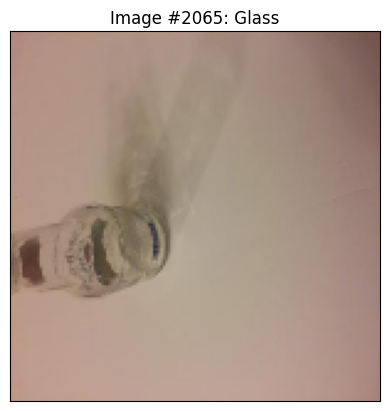

In [205]:
def display_random_image (class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{}: '.format(index) + class_names[labels[index]])
    plt.show()
    
display_random_image (class_names, train_images, train_labels)

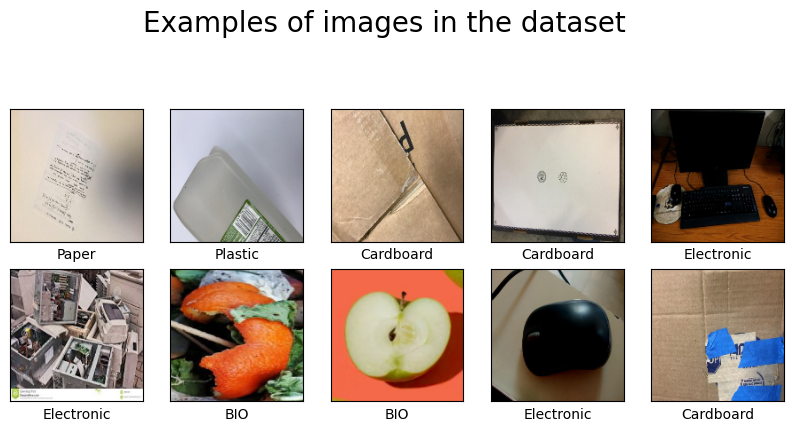

In [206]:
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize = (10,10))
    fig.suptitle("Examples of images in the dataset", fontsize=20)
    for i in range(10):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
    
display_examples(class_names, train_images, train_labels)

## Membangun Arsitektur Model

In [207]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='softmax'))

In [208]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [209]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 74, 74, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_45 (Conv2D)          (None, 72, 72, 128)       73856     
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 36, 36, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_46 (Conv2D)          (None, 34, 34, 128)       147584    
                                                                 
 max_pooling2d_46 (MaxPooli  (None, 17, 17, 128)     

In [210]:
#Perubahan hanya pada learning rate dari 0.00001 diubah menjadi 0.000001
checkpoint = ModelCheckpoint(filepath='models.h5', save_best_only=True, save_weights_only=False,)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=9, verbose = 1, mode='min', restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    varbose = 1,
    fector = 0.3,
    patience = 2,
    min_lr = 0.0001)

## Pelatihan Model

In [211]:
history1 = model.fit(
    train_images, 
    train_labels, 
    batch_size = 32, 
    epochs = 10,
    validation_data=(val_images, val_labels), 
    callbacks=[learning_rate_reduction],
    )

Epoch 1/10
120/120 [==============================] - 72s 591ms/step - loss: 1.8217 - accuracy: 0.2891 - val_loss: 1.6760 - val_accuracy: 0.3250 - lr: 0.0010
Epoch 2/10
120/120 [==============================] - 72s 597ms/step - loss: 1.5826 - accuracy: 0.3988 - val_loss: 1.5926 - val_accuracy: 0.4021 - lr: 0.0010
Epoch 3/10
120/120 [==============================] - 70s 584ms/step - loss: 1.4445 - accuracy: 0.4699 - val_loss: 1.3681 - val_accuracy: 0.4708 - lr: 0.0010
Epoch 4/10
120/120 [==============================] - 69s 575ms/step - loss: 1.3486 - accuracy: 0.4988 - val_loss: 1.3445 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/10
120/120 [==============================] - 72s 600ms/step - loss: 1.2351 - accuracy: 0.5423 - val_loss: 1.3359 - val_accuracy: 0.5063 - lr: 0.0010
Epoch 6/10
120/120 [==============================] - 68s 568ms/step - loss: 1.1160 - accuracy: 0.5952 - val_loss: 1.3125 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 7/10
120/120 [==============================] 

# Evaluasi Hasil

In [212]:
def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(10)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc, label = 'Training Accuracy', color='blue')
    ax[0].plot(epochs , val_acc, label = 'Validation Accuracy', color='teal')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[1].plot(epochs , train_loss, label = 'Training Loss', color='blue')
    ax[1].plot(epochs , val_loss, label = 'Validation Loss', color='teal')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    plt.show()

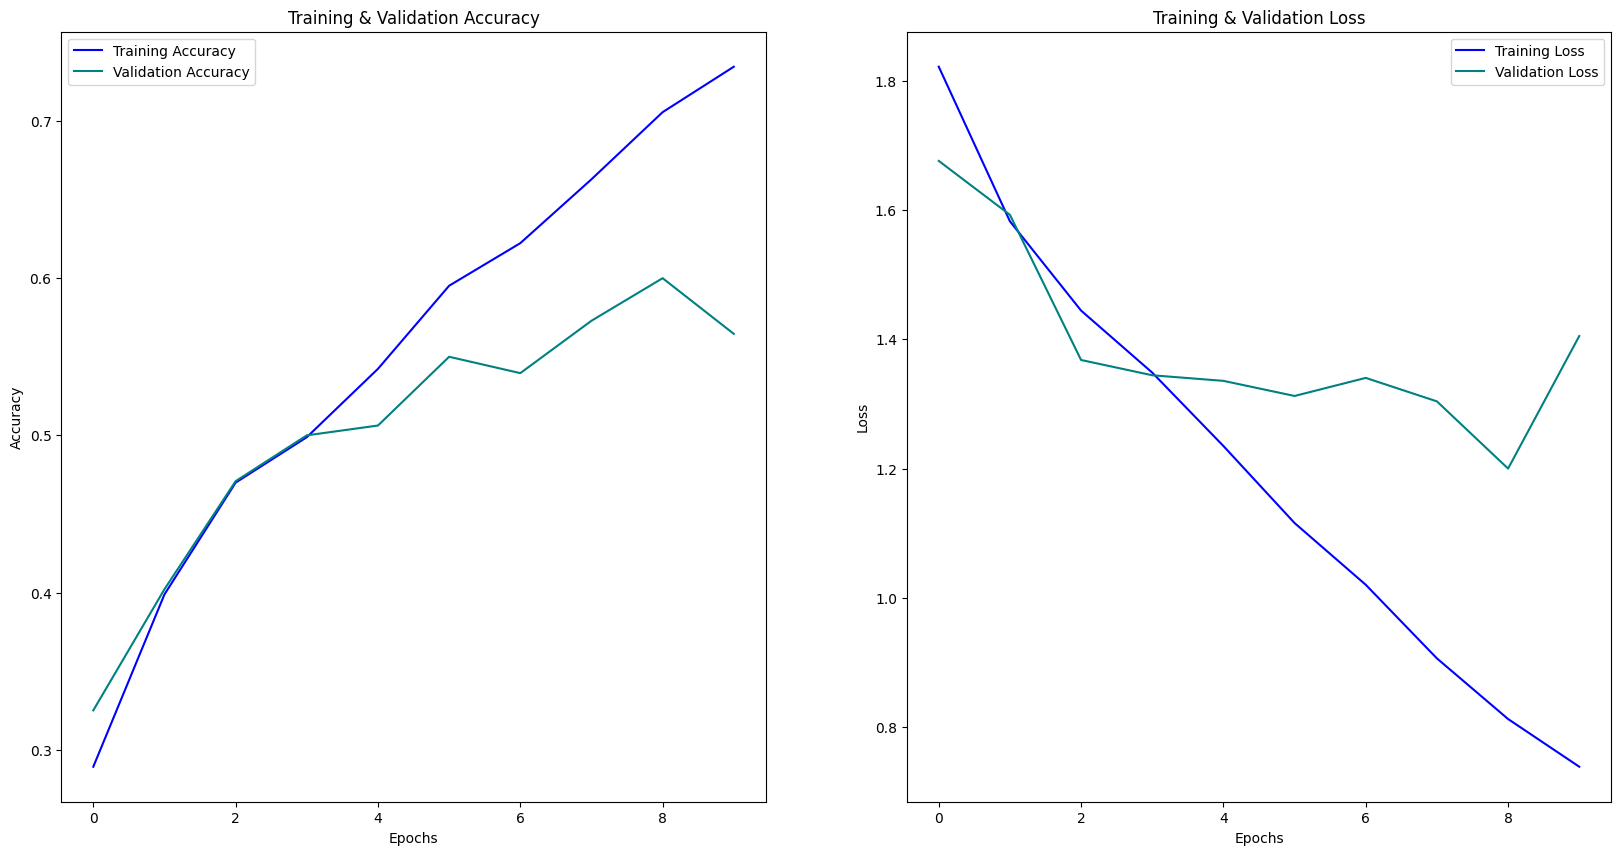

In [213]:
plot_accuracy_loss_chart(history1)

In [214]:
results = model.evaluate(test_images, test_labels)

print("Loss of the model is - ", results[0])
print("Accuracy of the model is - ", results[1]*100, "%")

15/15 [==============================] - 2s 133ms/step - loss: 1.4698 - accuracy: 0.5208
Loss of the model is -  1.4697829484939575
Accuracy of the model is -  52.08333134651184 %


In [215]:
from sklearn.metrics import classification_report
predictions = model.predict(test_images)
predictions = np.argmax(predictions,axis=1)
predictions[:15]

15/15 [==============================] - 2s 141ms/step


array([3, 2, 6, 2, 5, 5, 7, 0, 7, 6, 6, 3, 0, 1, 6], dtype=int64)

In [216]:
print(classification_report(
    test_labels, 
    predictions, 
    target_names = ['BIO (Class 0)', 'Cardboard (Class 1)', 'Electronic (Class 2)', 'Glass (Class 3)', 'Metal (Class 4)', 'Paper (Class 5)', 'Plastic (Class 6)', 'Trash (Class 7)']))

                      precision    recall  f1-score   support

       BIO (Class 0)       0.68      0.59      0.63        68
 Cardboard (Class 1)       0.71      0.74      0.72        62
Electronic (Class 2)       0.67      0.59      0.63        56
     Glass (Class 3)       0.44      0.60      0.51        60
     Metal (Class 4)       0.30      0.47      0.37        49
     Paper (Class 5)       0.67      0.49      0.57        67
   Plastic (Class 6)       0.39      0.46      0.42        57
     Trash (Class 7)       0.37      0.21      0.27        61

            accuracy                           0.52       480
           macro avg       0.53      0.52      0.52       480
        weighted avg       0.54      0.52      0.52       480



In [217]:
cm = confusion_matrix(test_labels, predictions)
cm = pd.DataFrame(cm, index = ['0', '1', '2', '3', '4', '5', '6', '7'], columns = [['0', '1', '2', '3', '4', '5', '6', '7']])
cm

,0,1,2,3,4,5,6,7
0,40,7,4,0,9,0,5,3
1,2,46,0,3,2,2,2,5
2,1,2,33,6,10,1,2,1
3,1,0,0,36,6,5,9,3
4,0,0,3,14,23,3,4,2
5,0,1,3,6,10,33,10,4
6,1,3,2,11,6,4,26,4
7,14,6,4,5,10,1,8,13


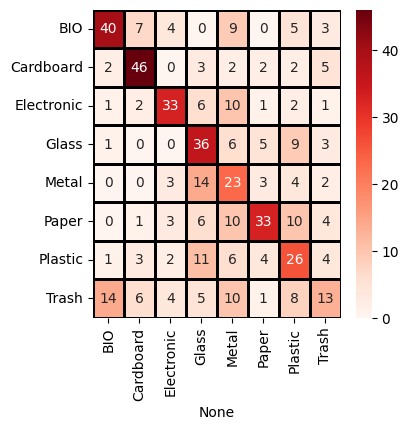

In [218]:
def plot_confusion_matrix (cm):
    plt.figure(figsize = (4,4))
    sns.heatmap(
        cm, 
        cmap = 'Reds', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(cm)